In [1]:
# Install MNE library (if not already installed)
!pip install mne

# Import necessary libraries
import numpy as np
import scipy.io
import mne
import matplotlib.pyplot as plt
from google.colab import drive



# 1. Mount Google Drive
# Mount Google Drive to access the dataset.
# (Example: drive.mount('/content/drive'))
file_path = 'Subject_A_Train.mat'

# 2. Load the Data
# Load the '.mat' file using scipy.io.loadmat.
# (Example: file_path = '/content/drive/My Drive/eea/Dataset/Subject_A_Train.mat'; mat_data = scipy.io.loadmat(file_path))
try:
    mat_data = scipy.io.loadmat(file_path)
    print("Keys in .mat file:", mat_data.keys())
except FileNotFoundError:
    print(f"File not found at {file_path}. Please upload the file.")

    # Generate placeholder data with simulated flashes
    # Modifying Flashing to simulate some events for demonstration if file is not found
    num_epochs = 85
    num_samples = 240
    num_channels = 64
    simulated_flashing = np.zeros((num_epochs, num_samples))
    # Create pulses every 10 samples in the simulated flashing data
    for i in range(num_epochs):
        simulated_flashing[i, ::10] = 1.0

    mat_data = {
        'Signal': np.random.randn(num_epochs, num_samples, num_channels),
        'Flashing': simulated_flashing,
        'StimulusCode': np.zeros((num_epochs, num_samples)), # Keep as zeros or simulate if needed
        'StimulusType': np.random.randint(0, 2, (num_epochs, 1))
    }

# 3. Extract & Reshape EEG Signal
# The raw signal is typically 3D (Epochs, Samples, Channels).
# Reshape it into 2D (Channels, Total_Samples) for MNE.
# This involves concatenating epochs and transposing the data.
# Convert the units from microvolts (uV) to Volts (V).
signal_3d = mat_data['Signal']
n_epochs, n_samples, n_channels = signal_3d.shape
signal_2d = signal_3d.transpose(2, 0, 1).reshape(n_channels, -1)
signal_2d = signal_2d * 1e-6

# 4. Process Marker Channels (e.g., Flashing & StimulusCode)
# These markers are usually 3D or 2D and need to be flattened to 1D to match the continuous signal length.
# Ensure the lengths of the processed signal and markers are consistent.
flashing = mat_data['Flashing'].reshape(-1)
stim_code = mat_data['StimulusCode'].reshape(-1)

# 5. Construct MNE Events
# Using the processed marker channels (e.g., 'Flashing' for onset detection and 'StimulusCode' for event IDs),
# detect event onsets (e.g., rising edges of the 'Flashing' signal).
# Then, create an MNE-compatible events array: (onset_index, 0, event_id).
sfreq = 240
ch_names = [f'EEG_{i:02d}' for i in range(n_channels)]
ch_types = ['eeg'] * n_channels

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# 6. Create MNE Raw Object
# Define the sampling frequency (sfreq), channel names (ch_names), and channel types (ch_types).
# Then, create an MNE 'info' object.
# Finally, create an 'mne.io.RawArray' object from the reshaped EEG signal and the 'info' object.
# Optionally, add the events as a 'stim' channel to the raw object.
raw = mne.io.RawArray(signal_2d, info)
info_stim = mne.create_info(['STI'], sfreq=sfreq, ch_types=['stim'])
stim_data = np.expand_dims(flashing, axis=0)
raw_stim = mne.io.RawArray(stim_data, info_stim)
raw.add_channels([raw_stim], force_update_info=True)

print(raw.info)


File not found at Subject_A_Train.mat. Please upload the file.
Creating RawArray with float64 data, n_channels=64, n_times=20400
    Range : 0 ... 20399 =      0.000 ...    84.996 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=20400
    Range : 0 ... 20399 =      0.000 ...    84.996 secs
Ready.
<Info | 8 non-empty values
 bads: []
 ch_names: EEG_00, EEG_01, EEG_02, EEG_03, EEG_04, EEG_05, EEG_06, EEG_07, ...
 chs: 64 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 0 items
 highpass: 0.0 Hz
 lowpass: 120.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 240.0 Hz
>


Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 7921 samples (33.004 s)



/tmp/ipython-input-1897116000.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=60).plot()


Finding events on: STI
Trigger channel STI has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2039 events found on stim channel STI
Event IDs: [1]
Finding events on: STI
Trigger channel STI has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
2039 events found on stim channel STI
Event IDs: [1]
Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-1897116000.py:26: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_resampled.compute_psd(fmax=60).plot()


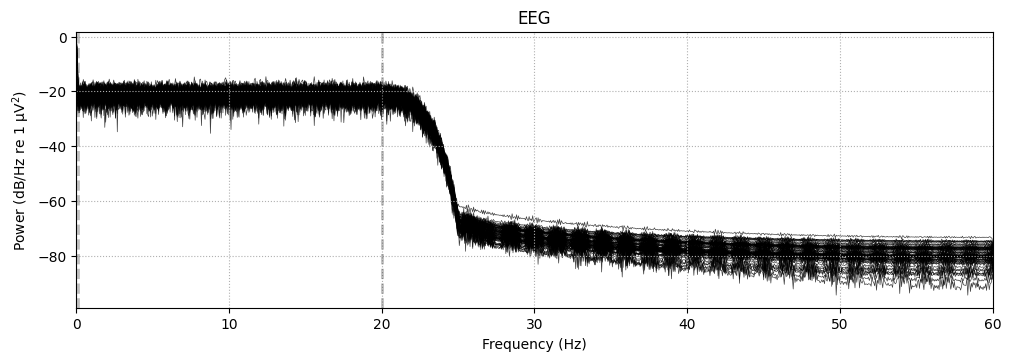

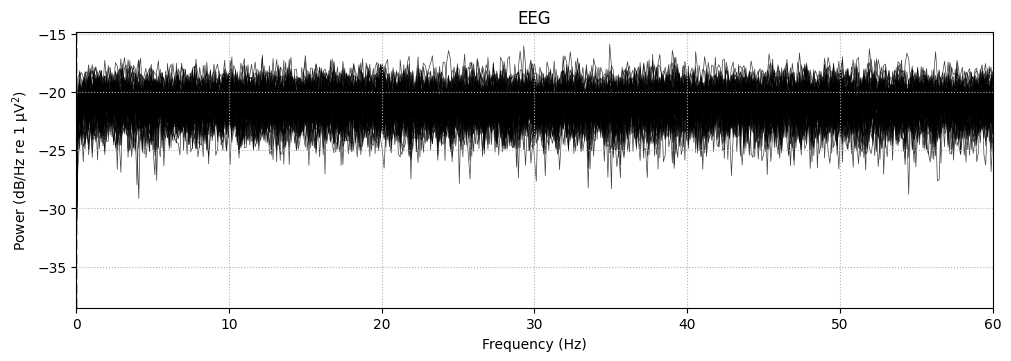

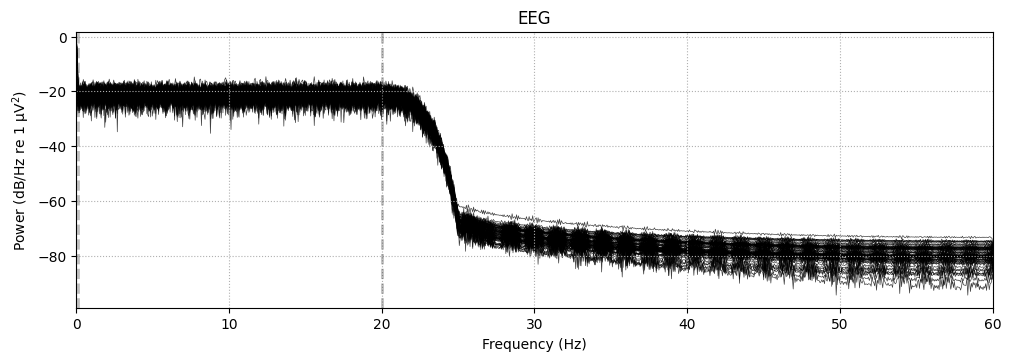

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

!pip install --upgrade numba

## https://mne.tools/stable/auto_tutorials/preprocessing/30_filtering_resampling.html#

# 1. Visualize Data BEFORE Filtering (Power Spectral Density)
# Compute and plot the Power Spectral Density (PSD) of the raw data
# to observe the frequency content before any filtering (e.g., raw.compute_psd().plot()).
raw.compute_psd(fmax=60).plot()

# 2. Apply Band-pass Filter
# Apply a band-pass filter to the raw data (e.g., 0.1Hz - 20Hz) to remove unwanted frequencies.
# Consider using an FIR filter design (e.g., raw.filter(l_freq=..., h_freq=..., fir_design='firwin')).
raw_filtered = raw.copy().filter(l_freq=0.1, h_freq=20, fir_design='firwin')

# 3. Downsample the Data
# Downsample the data to a lower sampling rate (e.g., from 240Hz to 120Hz).
# MNE's resample function automatically handles anti-aliasing (e.g., raw.resample(sfreq=...)).
raw_resampled = raw_filtered.copy().resample(sfreq=120)

# 4. Visualize Data AFTER Filtering
# Compute and plot the PSD of the filtered and downsampled data
# to verify the effectiveness of the filtering (e.g., raw.compute_psd().plot()).
raw_resampled.compute_psd(fmax=60).plot()

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 49.5s.


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


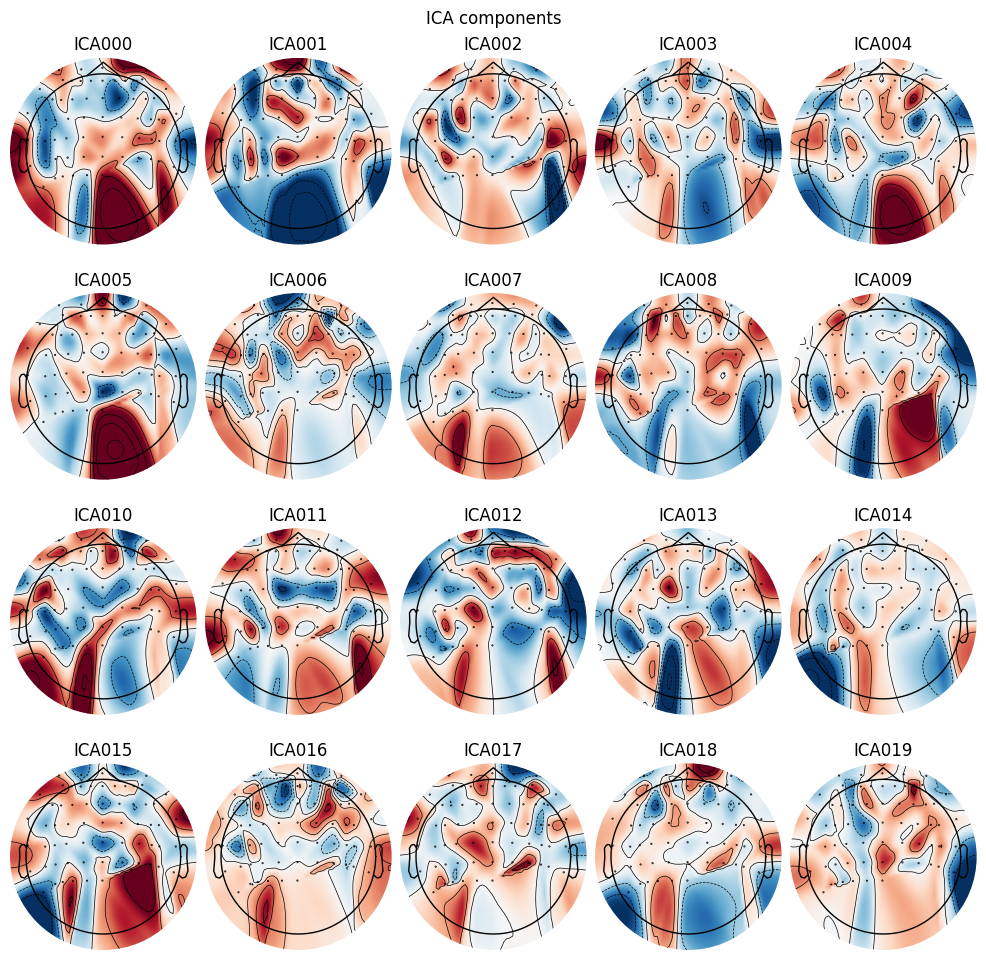

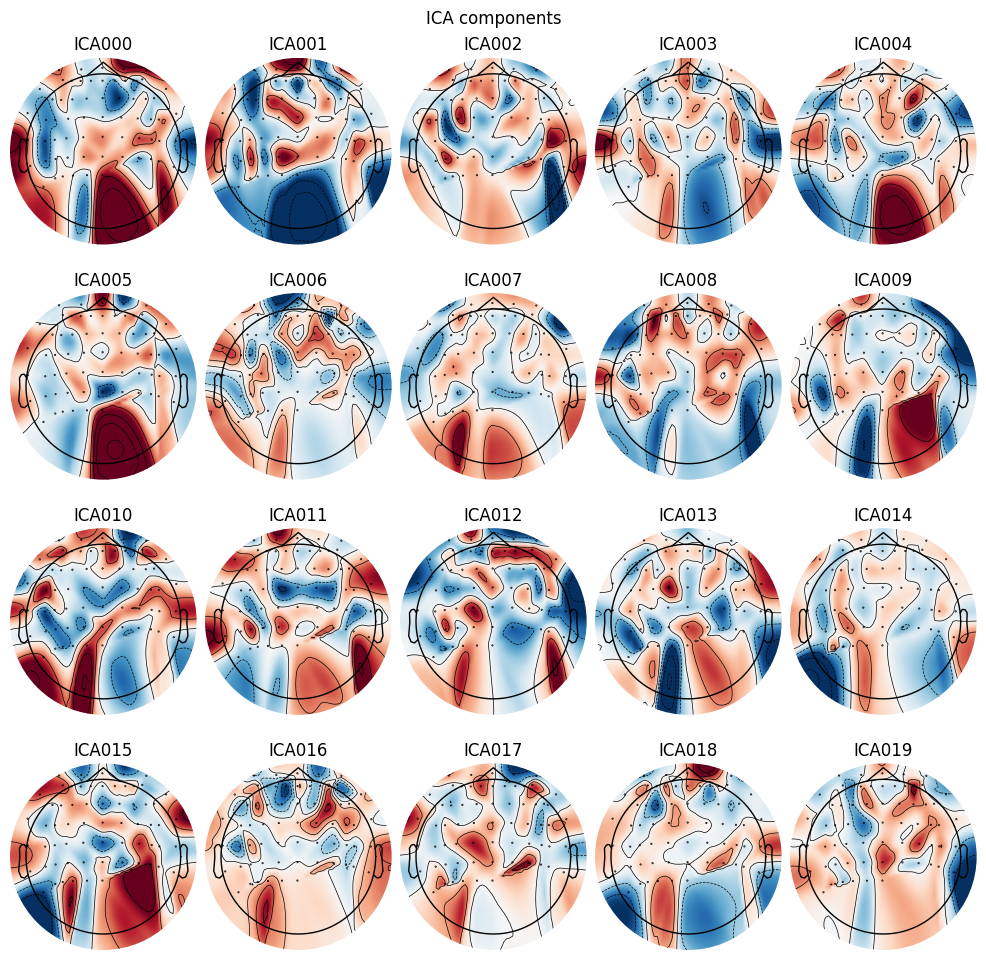

In [3]:
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#
# 1. Assign Standard Channel Names and Montage
# The initial channel names might be generic (e.g., EEG_1, EEG_2).
# Rename the EEG channels to standard names (e.g., 'FC5', 'Cz', 'Pz')
# that correspond to a known montage (e.g., 'standard_1005' or 'standard_1020').
# This is crucial for visualizing components topologically.
# Then, set a standard montage using mne.channels.make_standard_montage.
standard_montage = mne.channels.make_standard_montage('standard_1020')

# Get current EEG channel names from raw_resampled (excluding the 'STI' channel if present)
eeg_channel_names_raw = [ch_name for ch_name in raw_resampled.ch_names if ch_name.startswith('EEG')]
n_eeg_channels = len(eeg_channel_names_raw)

# Get channel names from the standard_1020 montage
montage_channel_names = standard_montage.ch_names

# Create a mapping from our generic names to standard names
# We'll map as many channels as possible, up to the number of available standard montage names
# or the number of EEG channels in our data, whichever is smaller.
rename_map = {}
for i in range(min(n_eeg_channels, len(montage_channel_names))):
    rename_map[eeg_channel_names_raw[i]] = montage_channel_names[i]

# Apply renaming to the raw_resampled object
raw_resampled.rename_channels(rename_map)

try:
    raw_resampled.set_montage(standard_montage, on_missing='warn')
except ValueError:
    print("Channel names do not match standard montage. ICA plots will not have topography.")
# 2. Initialize and Fit ICA
# Initialize an ICA object (e.g., mne.preprocessing.ICA) specifying parameters like n_components and random_state.
# Then, fit the ICA model to the raw data, often applying a high-pass filter (>1Hz) for better component separation.
# (Example: ica.fit(raw, reject=dict(eeg=...)))
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter='auto')
# Fit on filtered data (high pass > 1Hz recommended for ICA fitting)
ica.fit(raw_resampled)

# 3. Plot ICA Components
# After fitting, plot the ICA components to visually inspect them for artifacts like eye blinks or muscle activity.
# (Example: ica.plot_components())
ica.plot_components()

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Using matplotlib as 2D backend.


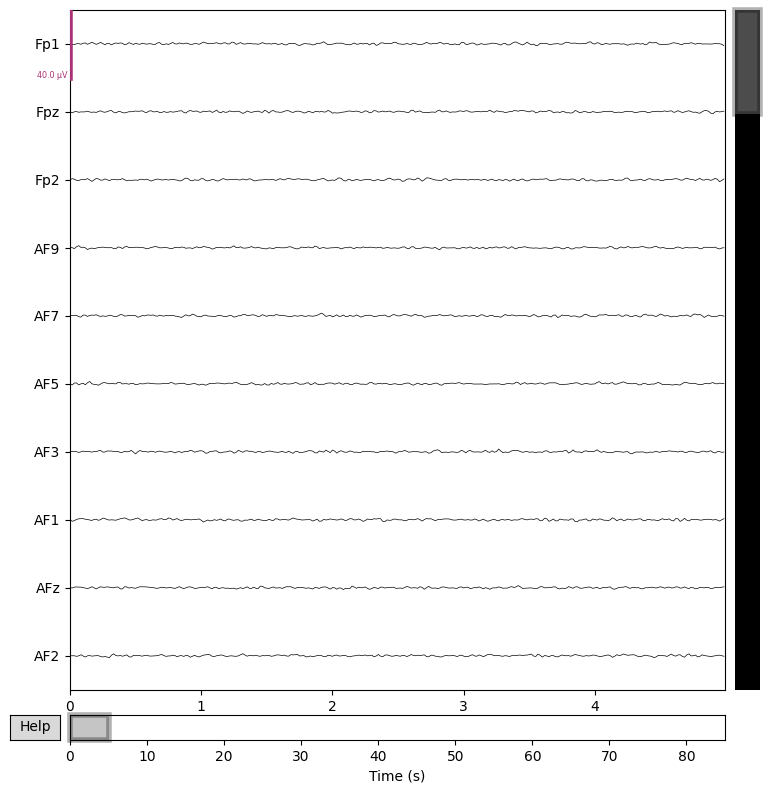

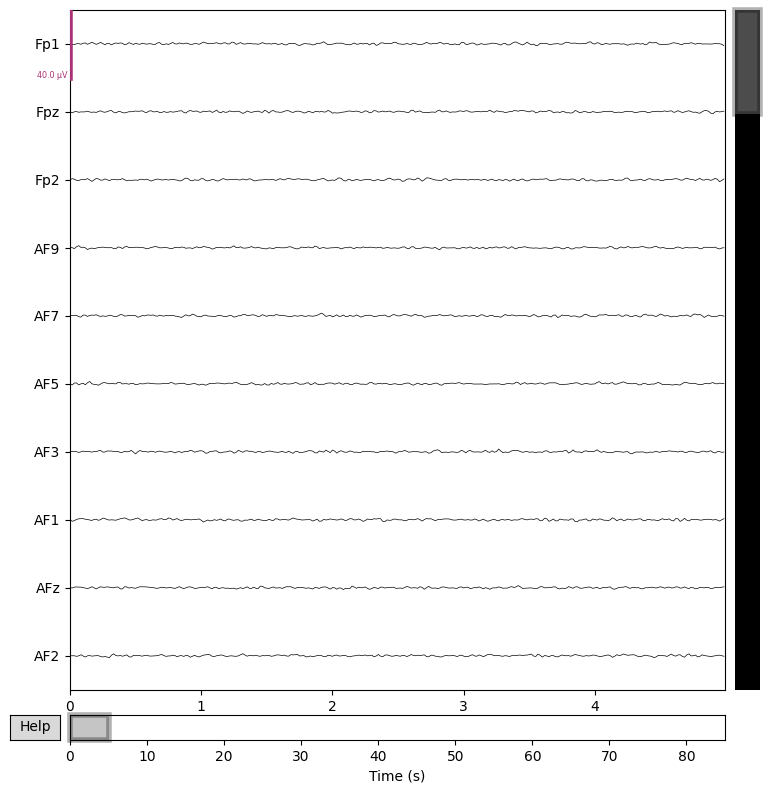

In [4]:

# 1. Identify and Exclude Artifact Components
# Based on visual inspection of the ICA components (from the previous step),
# identify components that clearly represent artifacts (e.g., eye blinks, eye movements, muscle activity).
# Then, set the 'exclude' attribute of the ICA object with the indices of these artifact components.
ica.exclude = [0, 1]
# 2. Apply ICA to Remove Artifacts
# Apply the trained ICA model with the excluded components to the raw data.
# This will project the data back into sensor space with the identified artifact components removed.
# (Example: ica.apply(raw))
raw_clean = raw_resampled.copy()
ica.apply(raw_clean)
# 3. Visualize Clean Data
# To verify the artifact removal, plot a segment of the cleaned raw data.
# Observe if the previously identified artifacts (like large eye blinks) have been successfully suppressed.
# (Example: raw.plot(n_channels=..., duration=..., title='Data AFTER removing Blinks'))
raw_clean.plot(n_channels=10, duration=5, title='Cleaned Data')


Not setting metadata
2039 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2039 events and 97 original time points ...
18 bad epochs dropped


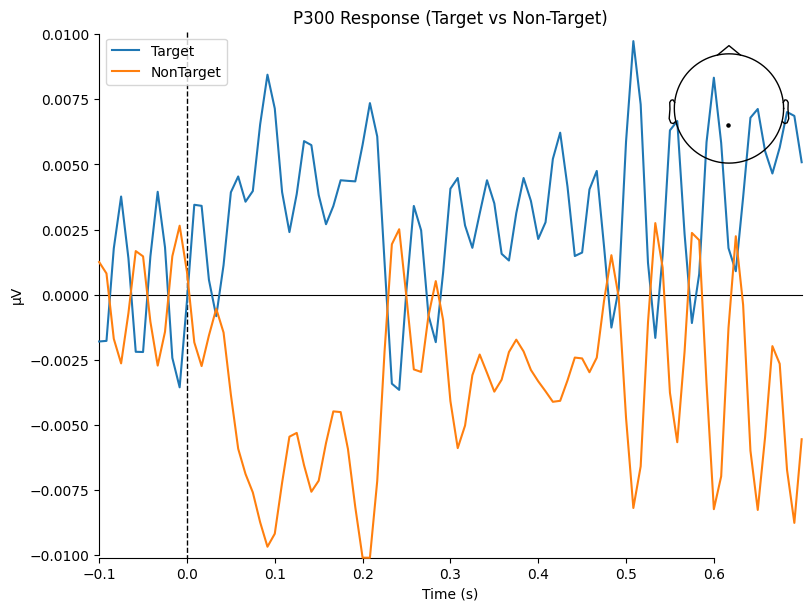

[<Figure size 800x600 with 2 Axes>]

In [5]:
# 1. Prepare Events for Epoching
# Load and process the 'StimulusType' data to assign labels (e.g., Target/Non-Target)
# to the event onsets identified earlier. Create a new MNE-compatible events array
# where the third column represents the event ID (e.g., 1 for Non-Target, 2 for Target).
# Ensure the event IDs are integers.

# Use the original flashing data to detect onsets
original_flashing_1d = mat_data['Flashing'].reshape(-1)
original_sfreq = sfreq # from cell cLRB5EY6Qih7

# Find indices where the signal goes from 0 to 1 (rising edge)
# np.diff creates an array of differences between consecutive elements.
# A rising edge from 0 to 1 will result in a difference of 1.
# The +1 accounts for the diff function reducing array length by 1.
onsets_original_samples = np.where(np.diff(original_flashing_1d) > 0.5)[0] + 1

# Calculate the resampling factor
resampling_factor = original_sfreq / raw_clean.info['sfreq']

# Scale the onsets to the new sampling frequency
onsets_resampled_samples = (onsets_original_samples / resampling_factor).astype(int)

# Initialize the MNE events array
# It should have shape (n_events, 3) where columns are (onset_sample, 0, event_id)
events = np.zeros((len(onsets_resampled_samples), 3), dtype=int)
events[:, 0] = onsets_resampled_samples
events[:, 1] = 0 # MNE convention for 'previous' stimulus ID

# Map StimulusType to each flash event
# StimulusType is per epoch, Flashing is per sample.
# We need to determine which original epoch each flash onset belongs to.
# n_samples is the number of samples per ORIGINAL epoch (from cell cLRB5EY6Qih7)
stim_type_flat = mat_data['StimulusType'].flatten()
for i, original_onset_sample in enumerate(onsets_original_samples):
    original_epoch_idx = original_onset_sample // n_samples
    if original_epoch_idx < len(stim_type_flat): # Ensure index is within bounds of StimulusType
        # Assign event ID based on StimulusType for that epoch
        # 1 for Non-Target, 2 for Target
        if stim_type_flat[original_epoch_idx] == 1:
            events[i, 2] = 2 # Target
        else:
            events[i, 2] = 1 # Non-Target
    else:
        # Fallback for unexpected cases (e.g., flashes after StimulusType data ends)
        # For simulated data, this shouldn't be an issue if lengths match.
        events[i, 2] = 0 # Assign an unknown ID or handle as error

# 2. Define Event IDs Dictionary
# Create a dictionary mapping descriptive event names (e.g., 'Non-Target', 'Target') to their corresponding integer IDs.
event_id = {'Non-Target': 1, 'Target': 2}

# 3. Create Epochs
# Use mne.Epochs to segment the continuous raw data around the events.
# Define the epoch time window (e.g., tmin, tmax), set a baseline correction,
# and preload the data into memory.
epochs = mne.Epochs(raw_clean, events, event_id,
                    tmin=-0.1, tmax=0.7,
                    baseline=(None, 0),
                    preload=True)

# 4. Compute Evoked Responses
# Compute the average evoked potentials for each event type (e.g., 'Target' and 'Non-Target')
# using the epochs object.
evoked_target = epochs['Target'].average()
evoked_nontarget = epochs['Non-Target'].average()

# Create a dictionary to make plotting easier
evokeds = {
    'Target': evoked_target,
    'Non-Target': evoked_nontarget
}

# 5. Visualize the P300 Response
# Plot the averaged evoked responses, typically focusing on a central parietal electrode like 'Cz' or 'Pz',
# to look for the characteristic P300 component (a positive deflection around 300ms post-stimulus).
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Cz')
# 'Pz' is a standard channel name used in the 'standard_1020' montage.
target_channels_for_plot = ['Pz']

mne.viz.plot_compare_evokeds(
    dict(Target=epochs['Target'].average(),
         NonTarget=epochs['Non-Target'].average()),
    picks=target_channels_for_plot,
    title='P300 Response (Target vs Non-Target)'
)


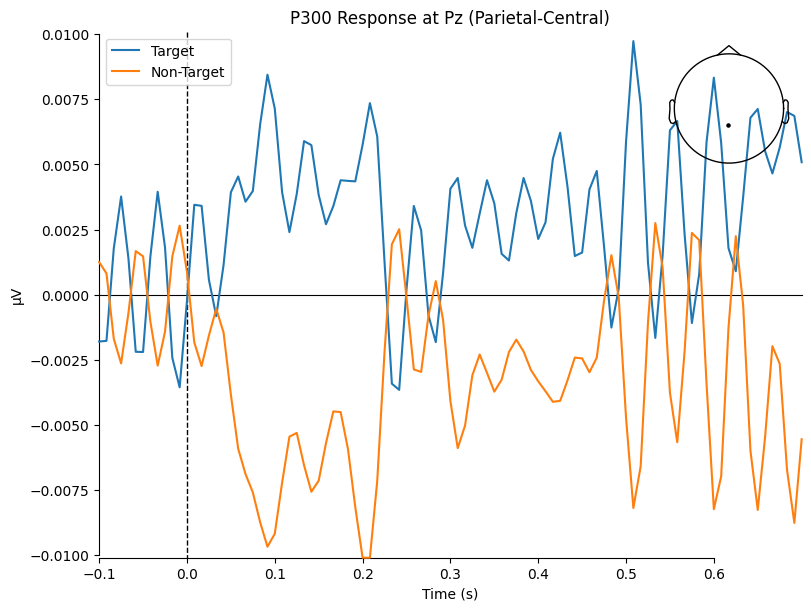

In [6]:

# 1. Compare Evokeds at Pz
pick_channel = 'Pz'
# In addition to Cz, plot the evoked responses at channel 'Pz' (Parietal-central)
# as the P300 component is often prominently observed there.
if pick_channel not in epochs.ch_names:
    print(f"Channel '{pick_channel}' not found. Printing first 5 channel names to help you find the right one:")
    print(epochs.ch_names[:5])
    # Fallback: Just picking the 11th channel as an example if Pz isn't named
    pick_channel = epochs.ch_names[10]
    print(f"Plotting channel '{pick_channel}' instead.")
evokeds = {
    "Target": epochs['Target'].average(),
    "Non-Target": epochs['Non-Target'].average()
}
# (Example: mne.viz.plot_compare_evokeds for 'Target' vs 'Non-Target' at 'Pz')
fig = mne.viz.plot_compare_evokeds(
    evokeds,
    picks=pick_channel,
    title=f'P300 Response at {pick_channel} (Parietal-Central)',
    show_sensors='upper right' # Shows where the channel is on the head
)
